# Decision Tree Classifier

## Pull and Clean Datasets

In [1]:
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [2]:
df_train = pd.read_csv('hate_speech_training.csv')
df_train_2 = pd.read_csv('hate_speech_training_2.csv')
df_train_3 = pd.read_csv('hate_speech_training_3.csv')
df_train_4 = pd.read_csv('hate_speech_training_4.tsv', sep = '\t')
df_train_5 = pd.read_csv('hate_speech_training_5.csv')

In [3]:
df_train = df_train.drop('id', axis = 1) #0 = Not Hate Speech, 1 = Hate Speech

In [4]:
df_train_2 = df_train_2[['tweet', 'class']]
df_train_2['class'] = df_train_2['class'].replace([0], 'hate speech')
df_train_2['class'] = df_train_2['class'].replace([1, 2], 'not hate speech')
df_train_2['class'] = df_train_2['class'].replace(['hate speech'], 1)
df_train_2['class'] = df_train_2['class'].replace(['not hate speech'], 0)
df_train_2.rename(columns = {'class': 'label'}, inplace = True) #0 = Not Hate Speech, 1 = Hate Speech

In [5]:
df_train_3 = df_train_3.drop('index', axis = 1) 
df_train_3.rename(columns = {'post': 'tweet'}, inplace = True) #0 = Not Hate Speech, 1 = Hate Speech

In [6]:
df_train_4 = df_train_4[['text', 'HS']] 
df_train_4.rename(columns = {'text': 'tweet', 'HS': 'label'}, inplace = True) #0 = Not Hate Speech, 1 = Hate Speech

In [7]:
df_train_5['Label'] = df_train_5['Label'].replace(['Hate', 'Non-Asian Aggression'], 1)
df_train_5['Label'] = df_train_5['Label'].replace(['Neutral', 'Counterhate'], 0) 
df_train_5.rename(columns = {'Text': 'tweet', 'Label': 'label'}, inplace = True) #0 = Not Hate Speech, 1 = Hate Speech

In [8]:
dfs = [df_train, df_train_2, df_train_3, df_train_4, df_train_5]
df = pd.concat(dfs)

## Train, Test, Split


In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X = df['tweet']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=3,
                                                    test_size=0.20,
                                                   stratify = y) #80/20 split

## NLP Cleaning

In [11]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

In [12]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [13]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [14]:
sw = stopwords.words('english')
sw_add = ['@user', '#', '@', 'https', 'amp', 'co', 
          'http', 'RT', '#','##','####','######','##########','##@user']
sw = sw + sw_add

In [15]:
def get_wordnet_pos(treebank_tag):
    
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [16]:
def doc_preparer(doc, stop_words=sw):
 
    regex_token = RegexpTokenizer(r"([@#a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in sw]
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)

In [17]:
token_docs = [doc_preparer(doc, sw) for doc in X_train]
test_token_docs = [doc_preparer(doc, sw) for doc in X_test]

## Grid Search Pipeline for TF-IDF on Decision Tree Classifier

In [18]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [19]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [27]:
tfidf_dtc_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('SMOTE', SMOTE(n_jobs = -1)),
    ('dtc', DecisionTreeClassifier())
])

In [28]:
tfidf_dtc_pipeline.fit(token_docs, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('SMOTE', SMOTE(n_jobs=-1)),
                ('dtc', DecisionTreeClassifier())])

In [18]:
tfidf_dtc_params = {
    'tfidf__max_features':[None, 27_000, 10_000],
    'tfidf__ngram_range':[(1,1), (1,2), (2,2)],
    'SMOTE__sampling_strategy':['auto', .75, .9],
    'dtc__criterion': ['gini', 'entropy'],
    'dtc__max_depth': [1, 5, 9]
}

In [20]:
from sklearn.model_selection import GridSearchCV

In [32]:
gs_tfidf_dtc = GridSearchCV(tfidf_dtc_pipeline,
                            param_grid=tfidf_dtc_params, 
                            cv = 3, 
                            verbose = 1,
                            n_jobs = -1)

In [33]:
gs_tfidf_dtc.fit(token_docs, y_train)

Fitting 3 folds for each of 162 candidates, totalling 486 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('SMOTE', SMOTE(n_jobs=-1)),
                                       ('dtc', DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'SMOTE__sampling_strategy': ['auto', 0.75, 0.9],
                         'dtc__criterion': ['gini', 'entropy'],
                         'dtc__max_depth': [1, 5, 9],
                         'tfidf__max_features': [None, 27000, 10000],
                         'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2)]},
             verbose=1)

In [34]:
gs_tfidf_dtc.best_score_

0.9185829937652978

In [35]:
gs_tfidf_dtc.best_estimator_

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=10000, ngram_range=(2, 2))),
                ('SMOTE', SMOTE(n_jobs=-1, sampling_strategy=0.75)),
                ('dtc',
                 DecisionTreeClassifier(criterion='entropy', max_depth=9))])

In [36]:
gs_tfidf_dtc.best_params_

{'SMOTE__sampling_strategy': 0.75,
 'dtc__criterion': 'entropy',
 'dtc__max_depth': 9,
 'tfidf__max_features': 10000,
 'tfidf__ngram_range': (2, 2)}

## Optimized Decision Tree Model w/ TF-IDF

In [21]:
tfidf_best_dtc_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features = 10_000, ngram_range = (2,2))),
    ('SMOTE', SMOTE(n_jobs = -1, sampling_strategy = 0.75)),
    ('dtc', DecisionTreeClassifier(criterion = 'entropy', max_depth = 9))
])

In [22]:
tfidf_best_dtc_pipeline.fit(token_docs, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=10000, ngram_range=(2, 2))),
                ('SMOTE', SMOTE(n_jobs=-1, sampling_strategy=0.75)),
                ('dtc',
                 DecisionTreeClassifier(criterion='entropy', max_depth=9))])

In [39]:
tfidf_best_dtc_pipeline.score(token_docs, y_train)

0.9192162255070471

In [23]:
from sklearn.model_selection import cross_val_score

In [41]:
cross_val_score(tfidf_best_dtc_pipeline, token_docs, y_train, cv = 5)

array([0.91813659, 0.91867197, 0.91749593, 0.91939569, 0.91903383])

In [24]:
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, classification_report

In [43]:
tfidf_best_dtc_pipeline.score(test_token_docs, y_test)

0.9180055000723694

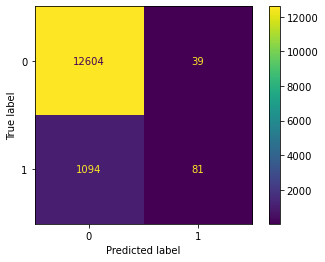

In [44]:
plot_confusion_matrix(tfidf_best_dtc_pipeline, test_token_docs, y_test)

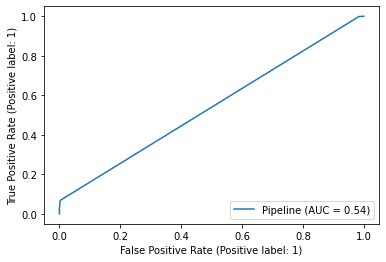

In [45]:
plot_roc_curve(tfidf_best_dtc_pipeline, test_token_docs, y_test)

In [46]:
y_hat = tfidf_best_dtc_pipeline.predict(test_token_docs)
print(classification_report(y_pred = y_hat, y_true = y_test))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     12643
           1       0.68      0.07      0.13      1175

    accuracy                           0.92     13818
   macro avg       0.80      0.53      0.54     13818
weighted avg       0.90      0.92      0.89     13818



## Grid Search Pipeline for Count Vectorizer on Decision Tree Classifier

In [49]:
cv_dtc_pipeline = Pipeline([
    ('cv', CountVectorizer()),
    ('SMOTE', SMOTE(n_jobs = -1)),
    ('dtc', DecisionTreeClassifier())
])

In [50]:
cv_dtc_pipeline.fit(token_docs, y_train)

Pipeline(steps=[('cv', CountVectorizer()), ('SMOTE', SMOTE(n_jobs=-1)),
                ('dtc', DecisionTreeClassifier())])

In [22]:
cv_dtc_params = {
    'cv__max_features':[None, 27_000, 10_000],
    'cv__ngram_range':[(1,1), (1,2), (2,2)],
    'SMOTE__sampling_strategy':['auto', .75, .9],
    'dtc__criterion': ['gini', 'entropy'],
    'dtc__max_depth': [1, 5, 9]
}

In [52]:
gs_cv_dtc = GridSearchCV(cv_dtc_pipeline,
                            param_grid=cv_dtc_params, 
                            cv = 3, 
                            verbose = 1,
                            n_jobs = -1)

In [53]:
gs_cv_dtc.fit(token_docs, y_train)

Fitting 3 folds for each of 162 candidates, totalling 486 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                       ('SMOTE', SMOTE(n_jobs=-1)),
                                       ('dtc', DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'SMOTE__sampling_strategy': ['auto', 0.75, 0.9],
                         'cv__max_features': [None, 27000, 10000],
                         'cv__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'dtc__criterion': ['gini', 'entropy'],
                         'dtc__max_depth': [1, 5, 9]},
             verbose=1)

In [54]:
gs_cv_dtc.best_score_

0.9182935005593414

In [55]:
gs_cv_dtc.best_estimator_

Pipeline(steps=[('cv', CountVectorizer(max_features=27000, ngram_range=(2, 2))),
                ('SMOTE', SMOTE(n_jobs=-1, sampling_strategy=0.75)),
                ('dtc', DecisionTreeClassifier(max_depth=9))])

In [57]:
gs_cv_dtc.best_params_

{'SMOTE__sampling_strategy': 0.75,
 'cv__max_features': 27000,
 'cv__ngram_range': (2, 2),
 'dtc__criterion': 'gini',
 'dtc__max_depth': 9}

## Best Possible Decision Tree Model for Count Vectorizer

In [25]:
cv_best_dtc_pipeline = Pipeline([
    ('cv', CountVectorizer(max_features = 27_000, ngram_range =(2,2))),
    ('SMOTE', SMOTE(n_jobs = -1, sampling_strategy = 0.75)),
    ('dtc', DecisionTreeClassifier(criterion = 'gini', max_depth = 9))
])

In [26]:
cv_best_dtc_pipeline.fit(token_docs, y_train)

Pipeline(steps=[('cv', CountVectorizer(max_features=27000, ngram_range=(2, 2))),
                ('SMOTE', SMOTE(n_jobs=-1, sampling_strategy=0.75)),
                ('dtc', DecisionTreeClassifier(max_depth=9))])

In [60]:
cv_best_dtc_pipeline.score(token_docs, y_train)

0.9191438548244106

In [61]:
cross_val_score(cv_best_dtc_pipeline, token_docs, y_train, cv = 5)

array([0.91876979, 0.91840058, 0.91767686, 0.91921476, 0.91867197])

In [62]:
cv_best_dtc_pipeline.score(test_token_docs, y_test)

0.917571283832682

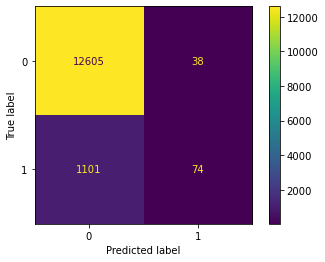

In [63]:
plot_confusion_matrix(cv_best_dtc_pipeline, test_token_docs, y_test)

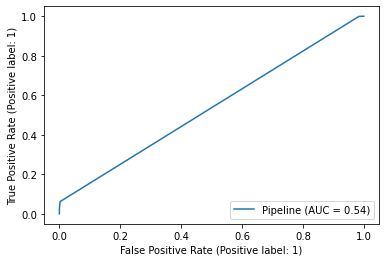

In [65]:
plot_roc_curve(cv_best_dtc_pipeline, test_token_docs, y_test)

In [28]:
y_hat_2 = cv_best_dtc_pipeline.predict(test_token_docs)
print(classification_report(y_pred = y_hat_2, y_true = y_test))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     12643
           1       0.67      0.06      0.12      1175

    accuracy                           0.92     13818
   macro avg       0.79      0.53      0.54     13818
weighted avg       0.90      0.92      0.89     13818



## NLP Cleaning w/ Only Words (# and @ removed)

In [23]:
def doc_preparer_2(doc, stop_words=sw):
 
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in sw]
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)

In [24]:
token_docs_2 = [doc_preparer_2(doc, sw) for doc in X_train]
test_token_docs_2 = [doc_preparer_2(doc, sw) for doc in X_test]

## Pipeline Grid Search for TFIDF on Decision Tree Model

In [25]:
tfidf_dtc_pipeline_2 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('SMOTE', SMOTE(n_jobs = -1)),
    ('dtc', DecisionTreeClassifier())
])

In [26]:
tfidf_dtc_pipeline_2.fit(token_docs_2, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('SMOTE', SMOTE(n_jobs=-1)),
                ('dtc', DecisionTreeClassifier())])

In [27]:
gs_tfidf_dtc_2 = GridSearchCV(tfidf_dtc_pipeline_2,
                            param_grid=tfidf_dtc_params, 
                            cv = 3, 
                            verbose = 1,
                            n_jobs = -1)

In [28]:
gs_tfidf_dtc_2.fit(token_docs_2, y_train)

Fitting 3 folds for each of 162 candidates, totalling 486 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('SMOTE', SMOTE(n_jobs=-1)),
                                       ('dtc', DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'SMOTE__sampling_strategy': ['auto', 0.75, 0.9],
                         'dtc__criterion': ['gini', 'entropy'],
                         'dtc__max_depth': [1, 5, 9],
                         'tfidf__max_features': [None, 27000, 10000],
                         'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2)]},
             verbose=1)

In [29]:
gs_tfidf_dtc_2.best_score_

0.9198494862772262

In [30]:
gs_tfidf_dtc_2.best_estimator_

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(2, 2))),
                ('SMOTE', SMOTE(n_jobs=-1)),
                ('dtc', DecisionTreeClassifier(max_depth=9))])

In [31]:
gs_tfidf_dtc_2.best_params_

{'SMOTE__sampling_strategy': 'auto',
 'dtc__criterion': 'gini',
 'dtc__max_depth': 9,
 'tfidf__max_features': None,
 'tfidf__ngram_range': (2, 2)}

## Best Decision Tree Model on TFIDF

In [32]:
tfidf_best_dtc_pipeline_2 = Pipeline([
    ('tfidf', TfidfVectorizer(max_features = None, ngram_range = (2,2))),
    ('SMOTE', SMOTE(n_jobs = -1)),
    ('dtc', DecisionTreeClassifier(criterion = 'gini', max_depth = 9))
])

In [33]:
tfidf_best_dtc_pipeline_2.fit(token_docs_2, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(2, 2))),
                ('SMOTE', SMOTE(n_jobs=-1)),
                ('dtc', DecisionTreeClassifier(max_depth=9))])

In [34]:
tfidf_best_dtc_pipeline_2.score(token_docs_2, y_train)

0.9202836930759349

In [35]:
cross_val_score(tfidf_best_dtc_pipeline_2, token_docs_2, y_train)

array([0.92003618, 0.91966709, 0.91821965, 0.91930523, 0.92057174])

In [36]:
tfidf_best_dtc_pipeline_2.score(test_token_docs_2, y_test)

0.9194528875379939

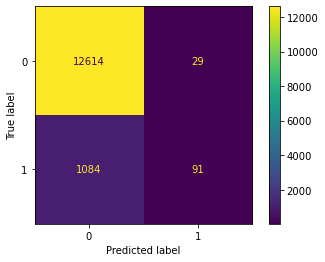

In [37]:
plot_confusion_matrix(tfidf_best_dtc_pipeline_2, test_token_docs_2, y_test)

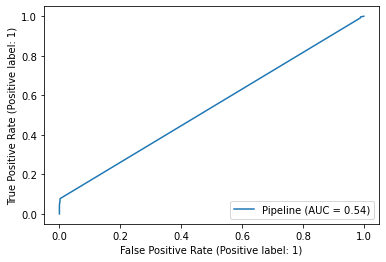

In [38]:
plot_roc_curve(tfidf_best_dtc_pipeline_2, test_token_docs_2, y_test)

In [39]:
y_hat_3 = tfidf_best_dtc_pipeline_2.predict(test_token_docs_2)
print(classification_report(y_pred = y_hat_3, y_true = y_test))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     12643
           1       0.76      0.08      0.14      1175

    accuracy                           0.92     13818
   macro avg       0.84      0.54      0.55     13818
weighted avg       0.91      0.92      0.89     13818



## Pipeline Grid Search for Count Vectorizer and Decision Tree

In [40]:
cv_dtc_pipeline_2 = Pipeline([
    ('cv', CountVectorizer()),
    ('SMOTE', SMOTE(n_jobs = -1)),
    ('dtc', DecisionTreeClassifier())
])

In [41]:
cv_dtc_pipeline_2.fit(token_docs_2, y_train)

Pipeline(steps=[('cv', CountVectorizer()), ('SMOTE', SMOTE(n_jobs=-1)),
                ('dtc', DecisionTreeClassifier())])

In [42]:
gs_cv_dtc_2 = GridSearchCV(cv_dtc_pipeline_2,
                            param_grid=cv_dtc_params, 
                            cv = 3, 
                            verbose = 1,
                            n_jobs = -1)

In [43]:
gs_cv_dtc_2.fit(token_docs_2, y_train)

Fitting 3 folds for each of 162 candidates, totalling 486 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                       ('SMOTE', SMOTE(n_jobs=-1)),
                                       ('dtc', DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'SMOTE__sampling_strategy': ['auto', 0.75, 0.9],
                         'cv__max_features': [None, 27000, 10000],
                         'cv__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'dtc__criterion': ['gini', 'entropy'],
                         'dtc__max_depth': [1, 5, 9]},
             verbose=1)

In [44]:
gs_cv_dtc_2.best_score_

0.91955998816101

In [45]:
gs_cv_dtc_2.best_estimator_

Pipeline(steps=[('cv', CountVectorizer(max_features=27000, ngram_range=(2, 2))),
                ('SMOTE', SMOTE(n_jobs=-1, sampling_strategy=0.75)),
                ('dtc', DecisionTreeClassifier(max_depth=9))])

In [46]:
gs_cv_dtc_2.best_params_

{'SMOTE__sampling_strategy': 0.75,
 'cv__max_features': 27000,
 'cv__ngram_range': (2, 2),
 'dtc__criterion': 'gini',
 'dtc__max_depth': 9}

## Best Decision Tree with Count Vectorizer

In [47]:
cv_best_dtc_pipeline_2 = Pipeline([
    ('cv', CountVectorizer(max_features = 27000, ngram_range = (2,2))),
    ('SMOTE', SMOTE(n_jobs = -1, sampling_strategy = 0.75)),
    ('dtc', DecisionTreeClassifier(criterion = 'gini', max_depth = 9))
])

In [49]:
cv_best_dtc_pipeline_2.fit(token_docs_2, y_train)

Pipeline(steps=[('cv', CountVectorizer(max_features=27000, ngram_range=(2, 2))),
                ('SMOTE', SMOTE(n_jobs=-1, sampling_strategy=0.75)),
                ('dtc', DecisionTreeClassifier(max_depth=9))])

In [50]:
cv_best_dtc_pipeline_2.score(token_docs_2, y_train)

0.9203741564292305

In [51]:
cross_val_score(cv_best_dtc_pipeline_2, token_docs_2, y_train, cv = 5)

array([0.91967436, 0.9191243 , 0.91785779, 0.91867197, 0.91966709])

In [52]:
cv_best_dtc_pipeline_2.score(test_token_docs_2, y_test)

0.9193805181647127

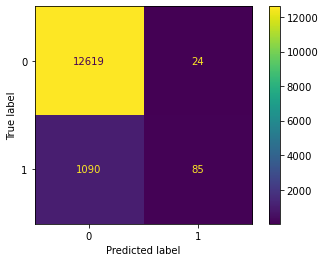

In [53]:
plot_confusion_matrix(cv_best_dtc_pipeline_2, test_token_docs_2, y_test)

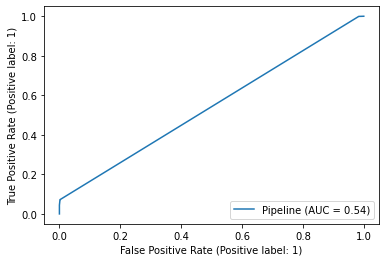

In [54]:
plot_roc_curve(cv_best_dtc_pipeline_2, test_token_docs_2, y_test)

In [55]:
y_hat_4 = cv_best_dtc_pipeline_2.predict(test_token_docs_2)
print(classification_report(y_pred = y_hat_4, y_true = y_test))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     12643
           1       0.78      0.07      0.13      1175

    accuracy                           0.92     13818
   macro avg       0.85      0.54      0.55     13818
weighted avg       0.91      0.92      0.89     13818

